In [37]:
!pip install split-folders

In [38]:
import glob
import random
import shutil
import matplotlib.image as mpimg

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, Activation, GlobalAveragePooling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, ConfusionMatrixDisplay)

import itertools
import splitfolders
import matplotlib.patches as patches

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurosat-dataset/EuroSATallBands/validation.csv
/kaggle/input/eurosat-dataset/EuroSATallBands/train.csv
/kaggle/input/eurosat-dataset/EuroSATallBands/test.csv
/kaggle/input/eurosat-dataset/EuroSATallBands/label_map.json
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_2893.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/Jakarta_000334.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_2765.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_2733.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_1037.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_2961.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/Jakarta_000479.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_1373.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_271.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/SeaLake_2418.tif
/kaggle/input/eurosat-dataset/EuroSATallBands/SeaLake/

# Data Importing

In [39]:
base_path = "../input/eurosat-dataset/EuroSAT"

In [40]:
classes = os.listdir(base_path)
print("Number of classes:", len(classes))
print("Classes:", classes)

Number of classes: 14
Classes: ['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'validation.csv', 'AnnualCrop', 'train.csv', 'test.csv', 'label_map.json', 'Forest', 'HerbaceousVegetation']


# EDA

In [41]:
# Count images per class

for c in classes:
    folder_path = os.path.join(base_path, c)
    if os.path.isdir(folder_path):
        print(f"{c}: {len(os.listdir(folder_path))} images")

SeaLake: 3000 images
Highway: 2500 images
River: 2500 images
Pasture: 2000 images
Industrial: 2500 images
Residential: 3000 images
PermanentCrop: 2500 images
AnnualCrop: 3000 images
Forest: 3000 images
HerbaceousVegetation: 3000 images


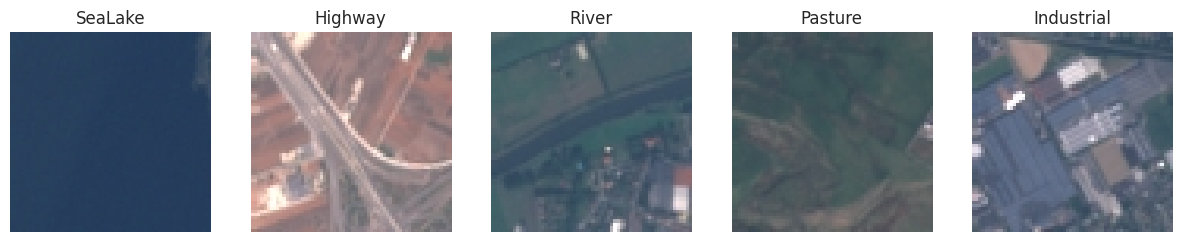

In [42]:
# Plot sample images from first 5 classes

plt.figure(figsize=(15, 8))
for i, c in enumerate(classes[:5]):
    folder_path = os.path.join(base_path, c)
    img_file = os.listdir(folder_path)[0]  # first image
    img_path = os.path.join(folder_path, img_file)
    img = mpimg.imread(img_path)
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")

plt.show()

In [43]:
sample_class = classes[0]
sample_path = os.path.join(base_path, sample_class, os.listdir(os.path.join(base_path, sample_class))[0])
img = cv2.imread(sample_path)
print("Image shape (H, W, C):", img.shape)

Image shape (H, W, C): (64, 64, 3)


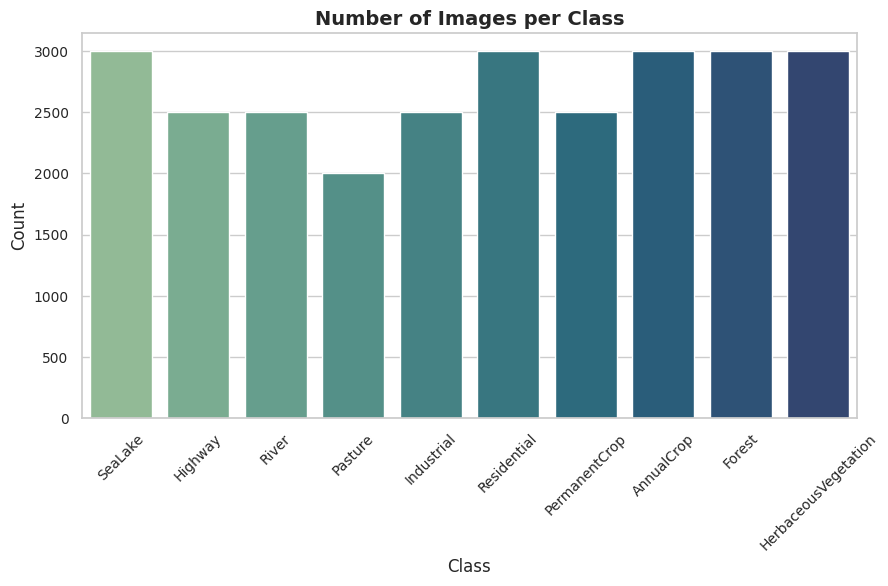

In [44]:
class_counts = {}
for c in classes:
    folder_path = os.path.join(base_path, c)
    if os.path.isdir(folder_path): 
        class_counts[c] = len(os.listdir(folder_path))

# Convert to DataFrame
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

# Plot countplot
plt.figure(figsize=(10,5))
sns.barplot(
    x="Class", 
    y="Count", 
    data=df_counts, 
    palette="crest"   
)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Number of Images per Class", fontsize=14, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Data Preprocessing And ِِِAugmentation

**Split the data => Train → 70%, Validation → 15%, Test → 15%**

In [45]:
input_folder = base_path 
output_folder = "EuroSAT_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 27000 files [00:20, 1336.65 files/s]


**Data Augmentation => ImageDataGenerator**

In [46]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [47]:
train_generator = train_datagen.flow_from_directory(
    "EuroSAT_split/train",
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    "EuroSAT_split/val",
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    "EuroSAT_split/test",
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 18900 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.
Found 4050 images belonging to 10 classes.


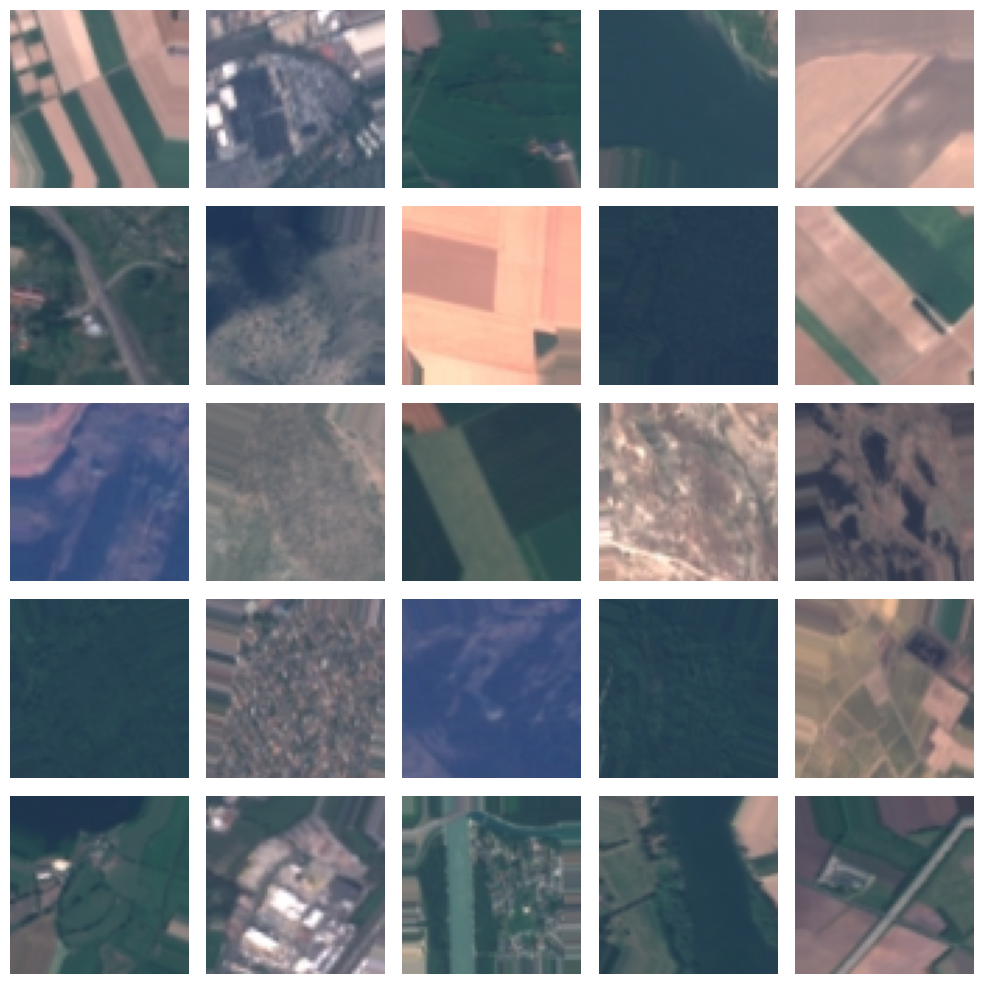

In [48]:
images, labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Modeling

## baseline CNN architecture

In [49]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(len(train_generator.class_indices), activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,052,106 (4.01 MB)

 Trainable params: 1,049,610 (4.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [50]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

In [51]:
epochs=30

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.5252 - loss: 1.4445 - val_accuracy: 0.4119 - val_loss: 2.0072 - learning_rate: 0.0010
Epoch 2/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.6964 - loss: 0.8827 - val_accuracy: 0.7267 - val_loss: 0.7917 - learning_rate: 0.0010
Epoch 3/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.7556 - loss: 0.7177 - val_accuracy: 0.7047 - val_loss: 1.0551 - learning_rate: 0.0010
Epoch 4/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.7832 - loss: 0.6287 - val_accuracy: 0.3872 - val_loss: 2.7857 - learning_rate: 0.0010
Epoch 5/30
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8110 - loss: 0.5643
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8110 - loss: 0.5642 - val_accuracy: 0.5215 - val_loss: 1.9078 - learning_rate: 0.0010
Epoch 6/30
591/591 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8610 - lo

### Evaluation

In [52]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9277 - loss: 0.1916
Test Accuracy: 0.9407
Test Loss: 0.1571


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

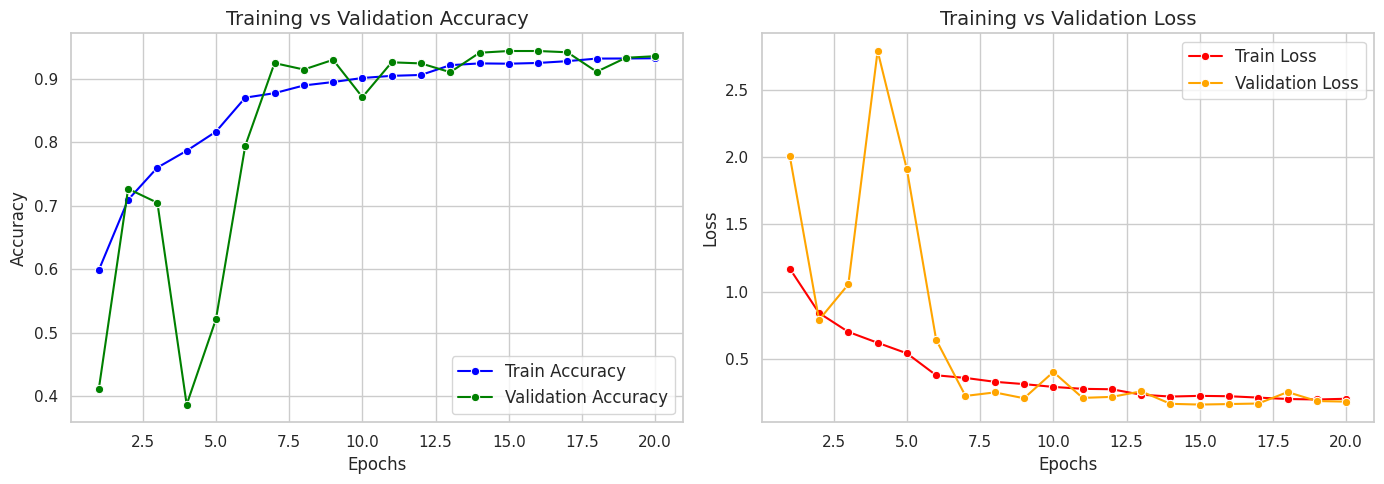

In [53]:
sns.set(style="whitegrid")

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14,5))

# Accuracy Curve
plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='o')
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)

# Loss Curve
plt.subplot(1,2,2)
sns.lineplot(x=epochs, y=history.history['loss'], label='Train Loss', color='red', marker='o')
sns.lineplot(x=epochs, y=history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Classification Report:

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.91      0.93       450
              Forest       0.98      0.99      0.98       450
HerbaceousVegetation       0.94      0.85      0.89       450
             Highway       0.98      0.91      0.94       375
          Industrial       0.94      0.94      0.94       375
             Pasture       0.94      0.97      0.95       300
       PermanentCrop       0.85      0.92      0.88       375
         Residential       0.91      0.99      0.95       450
               River       0.94      0.94      0.94       375
             SeaLake       0.99      0.98      0.98       450

            accuracy                           0.94      4050
           macro avg       0.94      0.94      0.94      4050
        weighted avg       0.94      0.94      0.94      4050



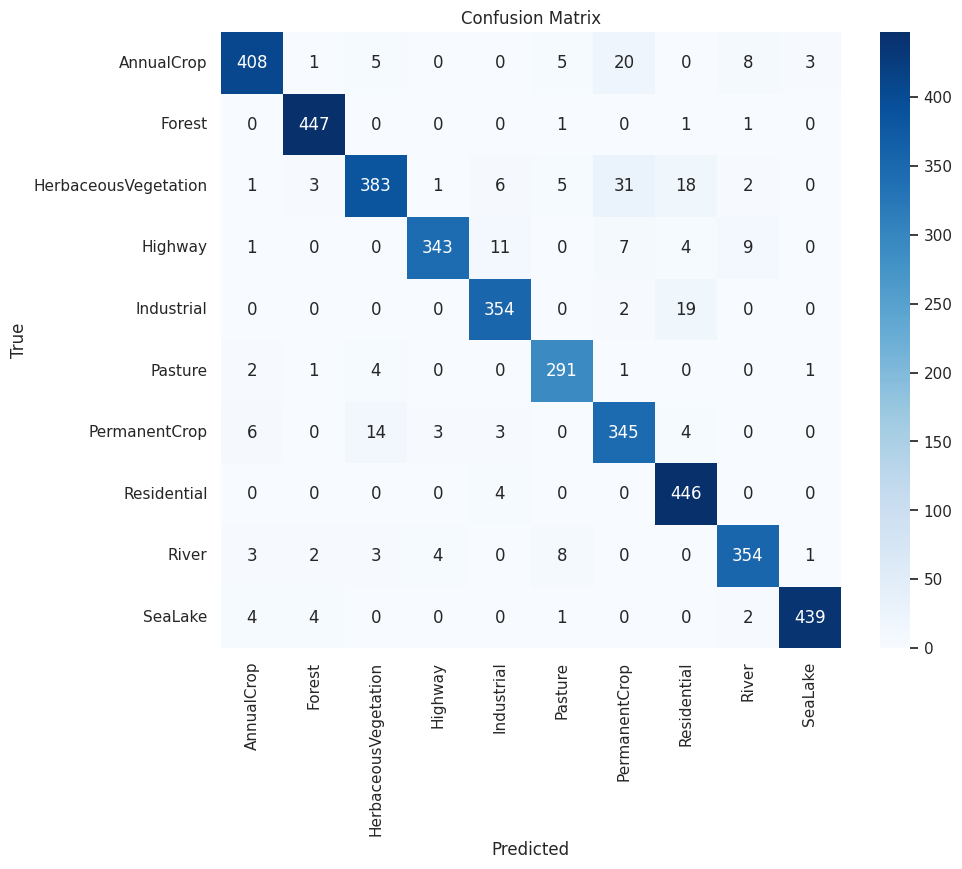

In [54]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


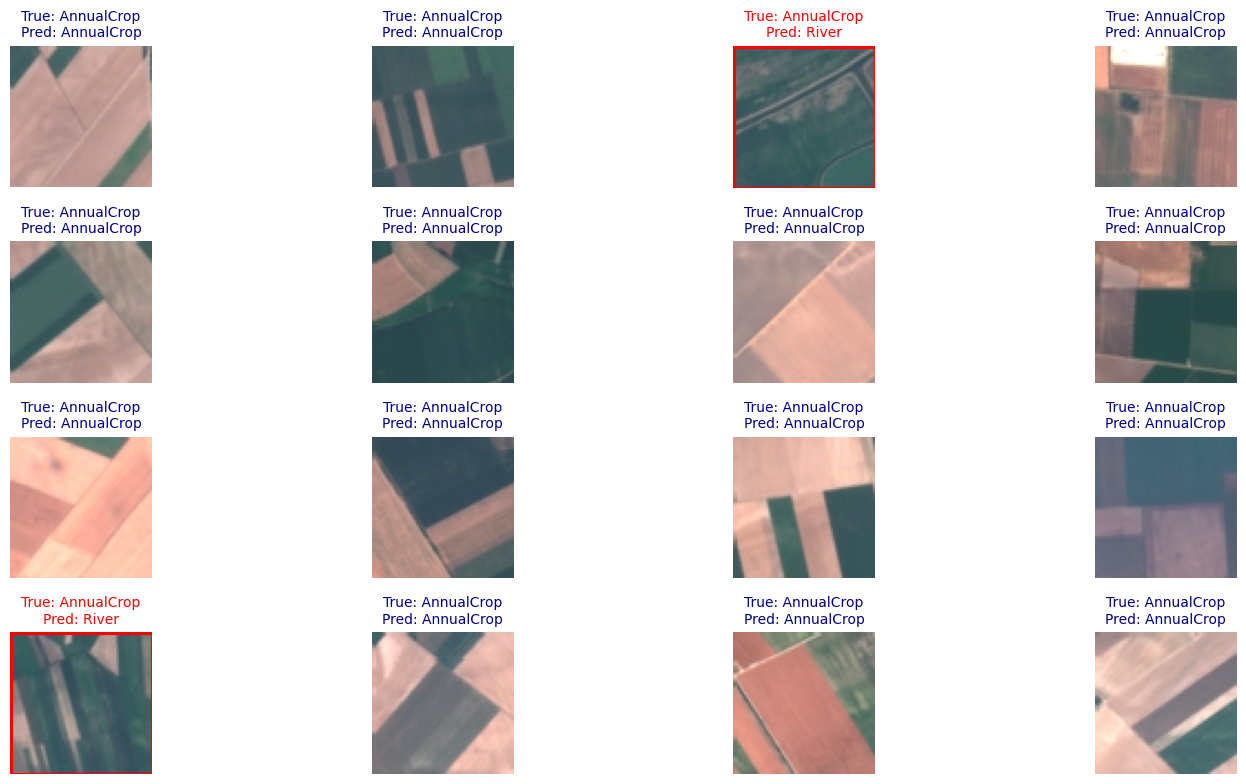

In [55]:
test_images, test_labels = next(test_generator)

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)  
class_labels = list(test_generator.class_indices.keys())

predicted_labels = [class_labels[i] for i in predicted_classes]
true_labels = [class_labels[i] for i in true_classes]

sns.set(style="whitegrid")

plt.figure(figsize=(16,8))

for i in range(16): 
    plt.subplot(4,4,i+1)
    plt.imshow(test_images[i])
    
    true_label = true_labels[i]
    pred_label = predicted_labels[i]
    
    plt.title(f"True: {true_label}\nPred: {pred_label}", 
              fontsize=10,
              color='darkblue' if true_label==pred_label else 'red')
    
    if true_label != pred_label:
        ax = plt.gca()
        rect = patches.Rectangle((0,0), test_images[i].shape[1], test_images[i].shape[0],
                                 linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
    
    plt.axis('off')

plt.tight_layout()
plt.show()